# **Assigment 1 – Pairs Trading**

> **Course:** Algorithmic Trading
>
> **University:** Vrije Universiteit Amsterdam
> 
> **Instructor:** Alexey Ivashchenko
> 
> **Student:** Milan Peter
> 
> **Email:** m.peter2@student.vu.nl
> 
> **Student ID:** 2868506
> 
> **Programme:** MSc Finance - Honours Programme in Quantitative Finance
> 
> **Date:** 2025-02-10


In [1]:
# Import libraries –––––
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from arch.unitroot import ADF
from arch.unitroot import PhillipsPerron

## **1. Co-integrated stocks pairs**

I use intraday equity data for **Visa** and **Mastercard**, two globally dominant payment network providers with highly similar business models and exposure to common demand drivers such as transaction volumes and consumer spending. Their close economic linkage makes them natural candidates for cointegration-based relative-value strategies.

The data consist of intraday trade prices obtained from the WRDS TAQ database and cover the period from **December 1 to December 12, 2025**, corresponding to **10 trading days**. Raw trade-level data are aggregated to a **5-minute frequency** using the last transaction price within each interval. The sample is restricted to regular US trading hours, and observations with missing prices are removed to ensure synchronized series. The resulting dataset contains clean, aligned intraday price series suitable for cointegration analysis.

The processed data are stored as a CSV file in a public GitHub repository and are downloaded directly into the Jupyter notebook via a URL, allowing the analysis to be fully reproducible.

In [2]:
# Import data –––––

# Link to the CSV file containing the pre-processed intraday price data
sURL_PRICES = "https://github.com/Milanpeter-77/Coursework-Pairs-Trading/blob/main/V_MA_prices_5m.csv"
sURL_SPY = "https://github.com/Milanpeter-77/Coursework-Pairs-Trading/blob/main/SPY_prices_5min.csv"

# Load price data
dfPRICES = pd.read_csv(sURL_PRICES + "?raw=true", parse_dates=["DATETIME"], index_col="DATETIME")
dfSPY = pd.read_csv(sURL_SPY + "?raw=true", parse_dates=["DATETIME"], index_col="DATETIME")


# Prepare data –––––

# Extract stock names 
lSTOCKS = dfPRICES.columns.tolist()

# Number of observations
iT = len(dfPRICES)
print(f"Loaded {iT} observations for {' and '.join(lSTOCKS)}")

# Log prices
dfLOGPRICES = np.log(dfPRICES)
dfLOGSPY = np.log(dfSPY)

# Define the training set and test set sizes
iT_TRAIN = round(0.75 * iT)
iT_TEST = iT - iT_TRAIN
print(f"Train size: {iT_TRAIN}, Test size: {iT_TEST}")

# Create a sequential index for plotting (removes intraday gaps on the x-axis)
# This is only for visualization; all computations still use the true datetime index.
dfLOGPRICES_SEQ = dfLOGPRICES.reset_index(drop=True)

Loaded 790 observations for MA and V
Train size: 592, Test size: 198


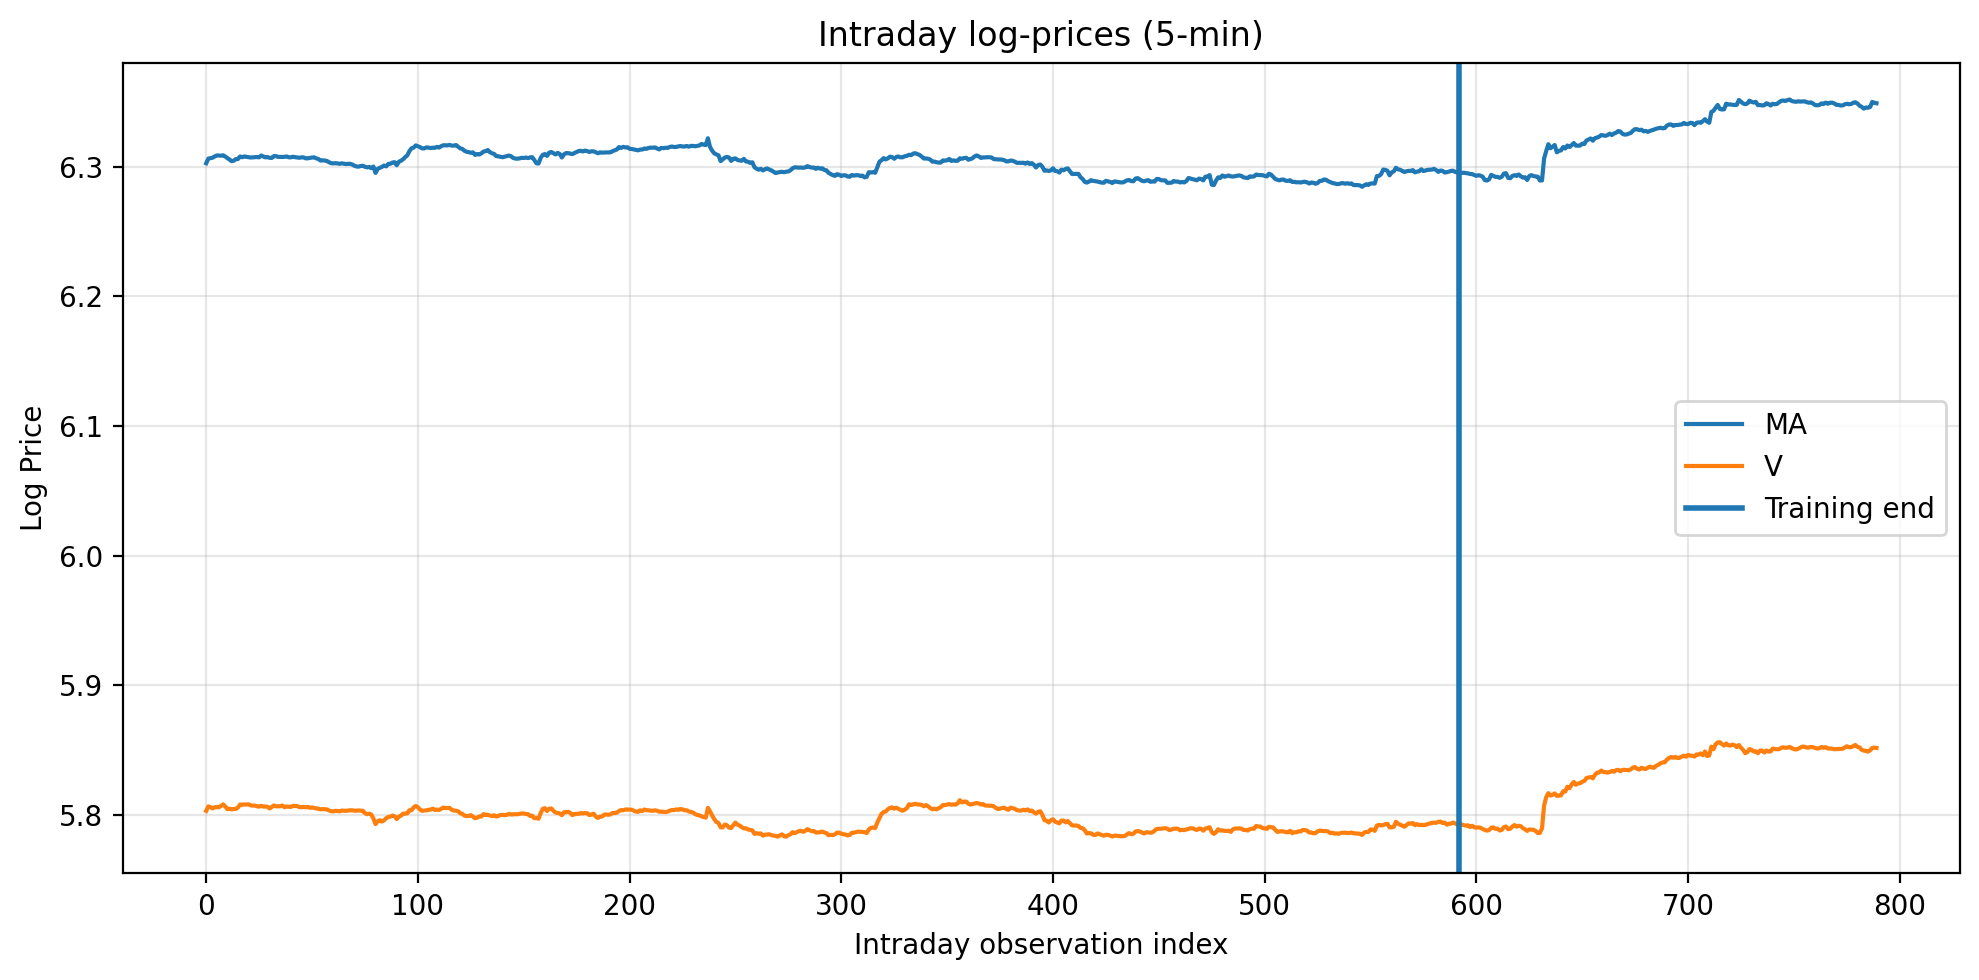

In [3]:
# Plot log prices of the two stocks –––––

plt.figure(figsize=(10, 5), dpi=200)
plt.plot(dfLOGPRICES_SEQ[lSTOCKS[0]], label=lSTOCKS[0])
plt.plot(dfLOGPRICES_SEQ[lSTOCKS[1]], label=lSTOCKS[1])
plt.axvline(iT_TRAIN, linewidth=2, label="Training end")
plt.title("Intraday log-prices (5-min)")
plt.xlabel("Intraday observation index")
plt.ylabel("Log Price")
plt.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

To visualize the intraday price dynamics, I plot the 5-minute log-price series against a **sequential intraday observation index** rather than calendar time. This removes non-trading gaps and allows the co-movement of the two series to be assessed more clearly at the intraday frequency. The resulting plot shows that Visa and Mastercard move closely together over time, with similar intraday patterns and no persistent divergence.

                            OLS Regression Results                            
Dep. Variable:                     MA   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     1241.
Date:                Tue, 10 Feb 2026   Prob (F-statistic):          3.11e-147
Time:                        18:35:49   Log-Likelihood:                 2287.6
No. Observations:                 592   AIC:                            -4571.
Df Residuals:                     590   BIC:                            -4562.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0017      0.150      6.659      0.0

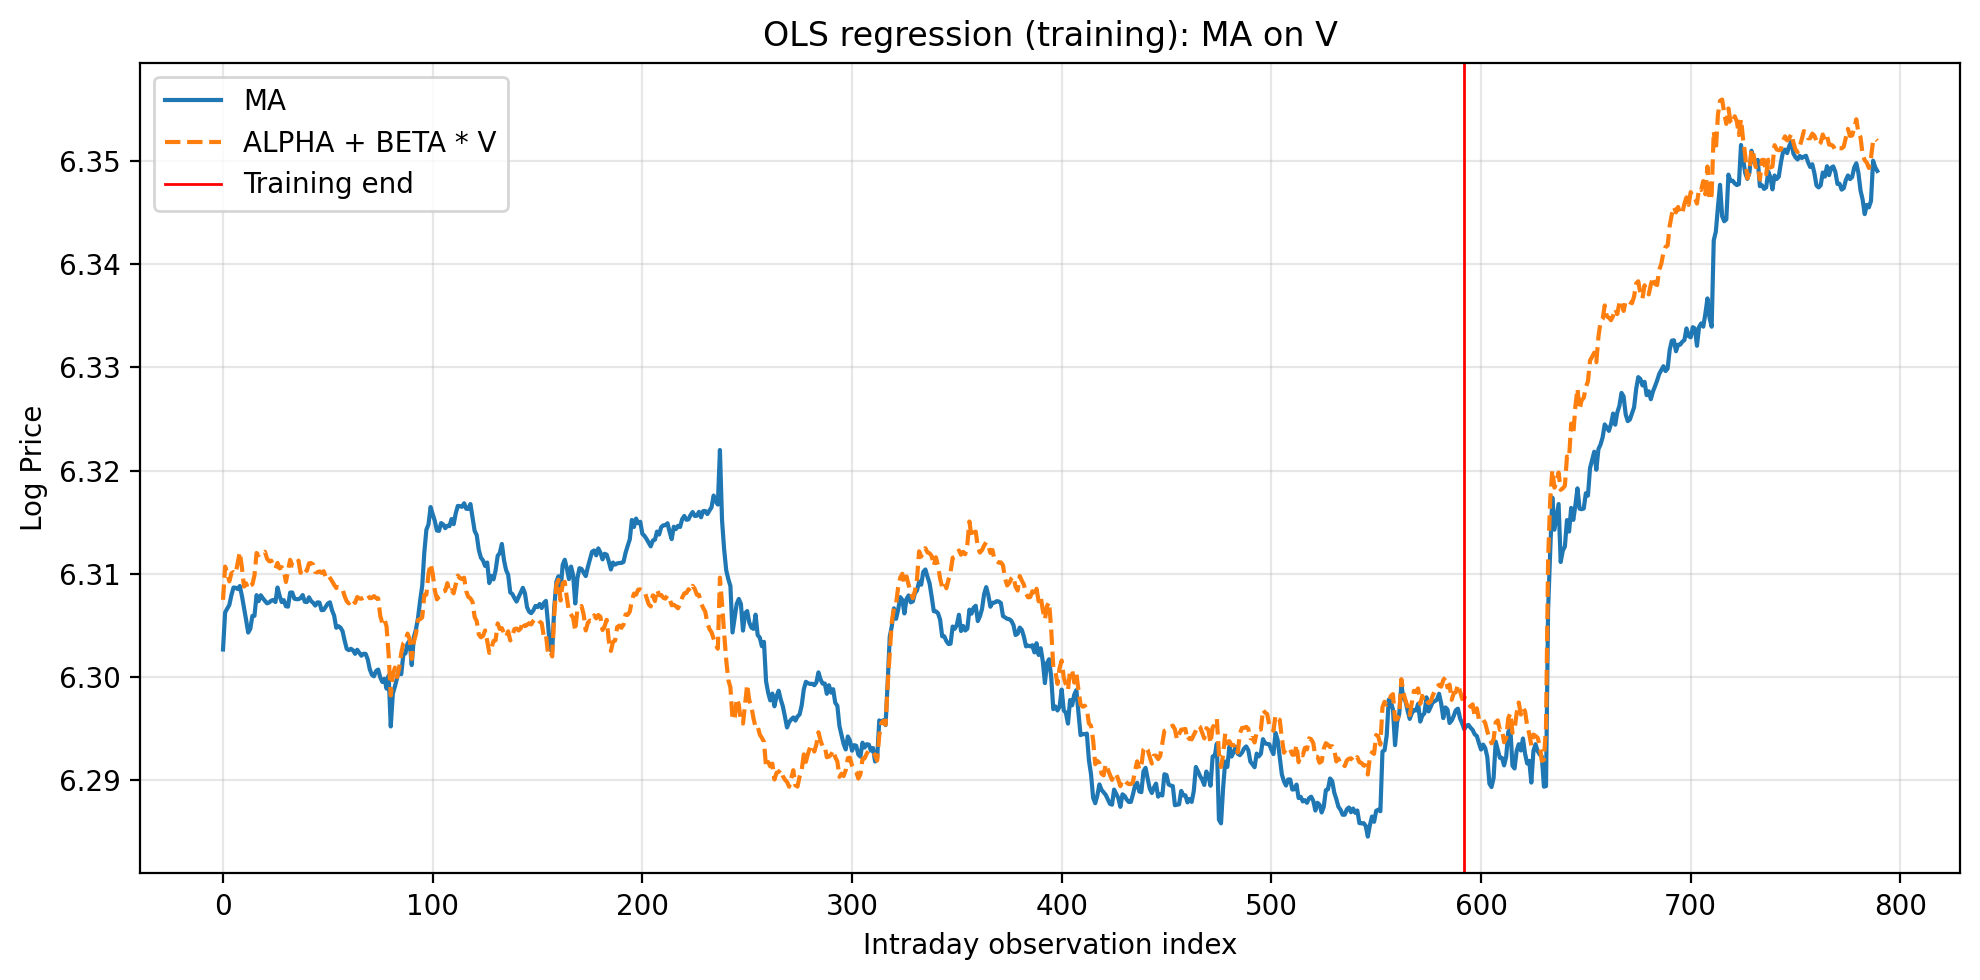

In [4]:
# Engle–Granger cointegration test –––––

# Choose dependent and independent series
sY = lSTOCKS[0]  # MA (Mastercard)
sX = lSTOCKS[1]  # V (Visa)

# Regression (TRAINING only) –––––
# Regress log-price of sY on log-price of sX
mdlREG = smf.ols(f"{sY} ~ {sX}", data=dfLOGPRICES.iloc[:iT_TRAIN]).fit()

# Store regression coefficients with your formatting
fALPHA = float(mdlREG.params["Intercept"]) # intercept
fBETA  = float(mdlREG.params[sX]) # hedge ratio
# Print regression summary and estimated coefficients
print(mdlREG.summary())
print(f"Estimated coefficients (training): ALPHA={fALPHA:.6f}, BETA={fBETA:.6f}")

# Compute fitted log-price line over FULL sample (for plotting)
srFITTED = fALPHA + fBETA * dfLOGPRICES[sX]

# Plot actual vs fitted log-price of sY
dfREG_SEQ = pd.DataFrame({
    sY: dfLOGPRICES[sY].values,
    "FITTED": srFITTED.values
})

# Plot of regression results
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(dfREG_SEQ[sY], label=sY)
plt.plot(dfREG_SEQ["FITTED"], linestyle="--", label=f"ALPHA + BETA * {sX}")
plt.axvline(iT_TRAIN, linewidth=1, label="Training end", color="red")
plt.title(f"OLS regression (training): {sY} on {sX}")
plt.xlabel("Intraday observation index")
plt.ylabel("Log Price")
plt.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

The OLS regression of Mastercard on Visa, estimated on the training sample, yields a statistically significant slope coefficient and a relatively high in-sample $R^2$, indicating strong contemporaneous co-movement between the two stocks. The fitted values track the actual log prices reasonably well over the training period, suggesting that a linear combination of the two series captures a substantial part of their joint variation at intraday horizons.

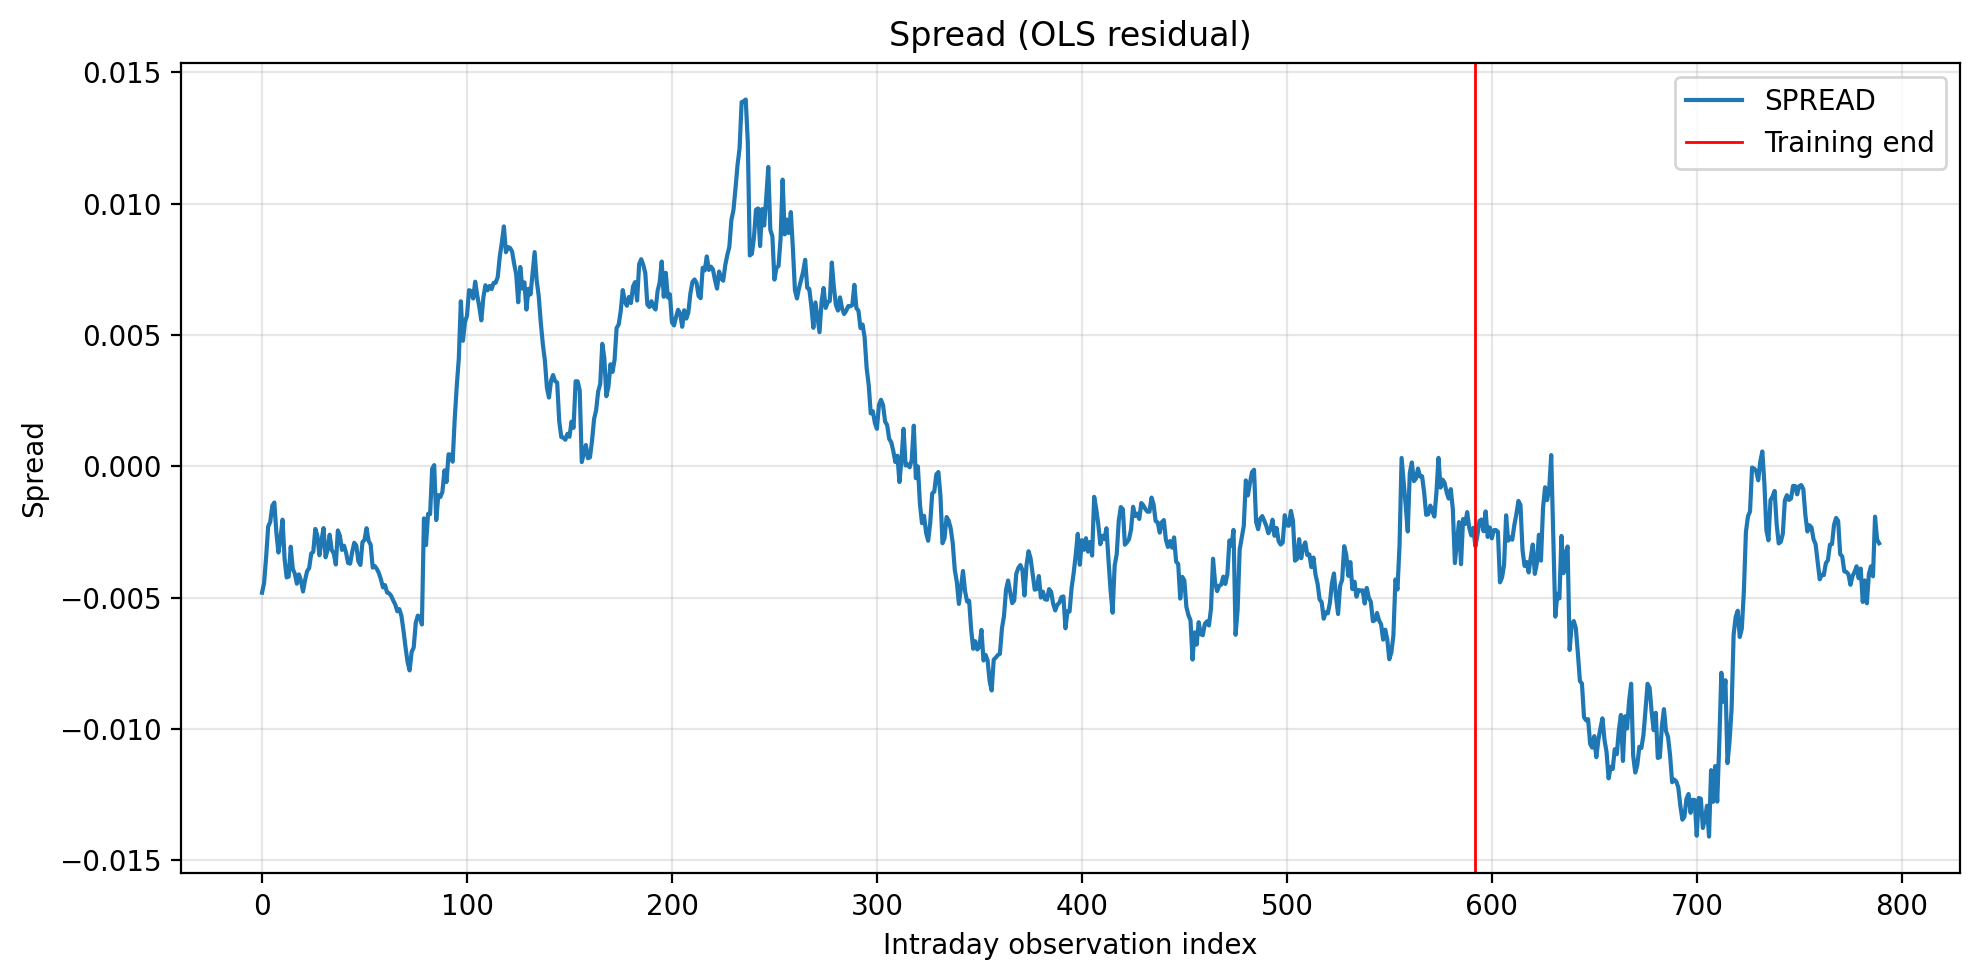

ADF cointegration test on spread:
    Test statistic: -2.0872
    p-value:        0.2497
PP cointegration test on spread:
    Test statistic: -2.2117
    p-value:        0.2020
ADF does NOT reject a unit root in the spread at the 5% level.
PP does NOT reject a unit root in the spread at the 5% level.


In [5]:
# Spread and cointegration tests –––––
# Spread is the regression residual (on full sample)
srSPREAD = dfLOGPRICES[sY] - (fALPHA + fBETA * dfLOGPRICES[sX])

# Plot spread
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(srSPREAD.reset_index(drop=True), label="SPREAD")
plt.axvline(iT_TRAIN, linewidth=1, label="Training end", color="red")
plt.title("Spread (OLS residual)")
plt.xlabel("Intraday observation index")
plt.ylabel("Spread")
plt.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ADF test on spread 
# Cointegration evidence: reject unit root in spread
resADF = ADF(srSPREAD)
print("ADF cointegration test on spread:")
print(f"    Test statistic: {resADF.stat:.4f}")
print(f"    p-value:        {resADF.pvalue:.4f}")

# PP test on spread (robust alternative to ADF)
resPP = PhillipsPerron(srSPREAD)
print("PP cointegration test on spread:")
print(f"    Test statistic: {resPP.stat:.4f}")
print(f"    p-value:        {resPP.pvalue:.4f}")

# Interpretation flags
if resADF.pvalue < 0.05:
    print("ADF suggests the spread is stationary (cointegration) at the 5% level.")
else:
    print("ADF does NOT reject a unit root in the spread at the 5% level.")

if resPP.pvalue < 0.05:
    print("PP suggests the spread is stationary (cointegration) at the 5% level.")
else:
    print("PP does NOT reject a unit root in the spread at the 5% level.")


The spread, defined as the regression residual, exhibits fluctuations around a slowly varying level but does not display strong mean reversion over the short intraday window. Consistent with this visual impression, both the ADF and Phillips–Perron tests fail to reject the null hypothesis of a unit root in the spread. This suggests that, over a limited sample of 10 trading days at a 5-minute frequency, statistical evidence for cointegration is weak.

This result is not unexpected, as cointegration tests have low power in short intraday samples and intraday prices are strongly influenced by liquidity and order-flow effects. Nevertheless, given the clear economic linkage between Visa and Mastercard and their strong empirical co-movement, I proceed by treating the pair as a **relative-value mean-reversion strategy**, rather than a strict long-run equilibrium trade, in the subsequent strategy analysis.

## **2. Strategy setup**

Following the standard pairs trading framework from the lab, I construct a relative-value trading strategy based on the spread between Mastercard and Visa. The hedge ratio is estimated using an OLS regression on the training sample only, and the spread is defined as the residual from this regression.

To generate trading signals, the spread is normalized using its mean and standard deviation from the training sample, resulting in a Z-score. Positions are taken when the Z-score deviates sufficiently from zero, under the assumption that short-term deviations are driven by temporary liquidity imbalances rather than permanent changes in relative value. Given the intraday nature of the data, positions are interpreted as short-horizon relative-value trades rather than bets on long-run equilibrium.

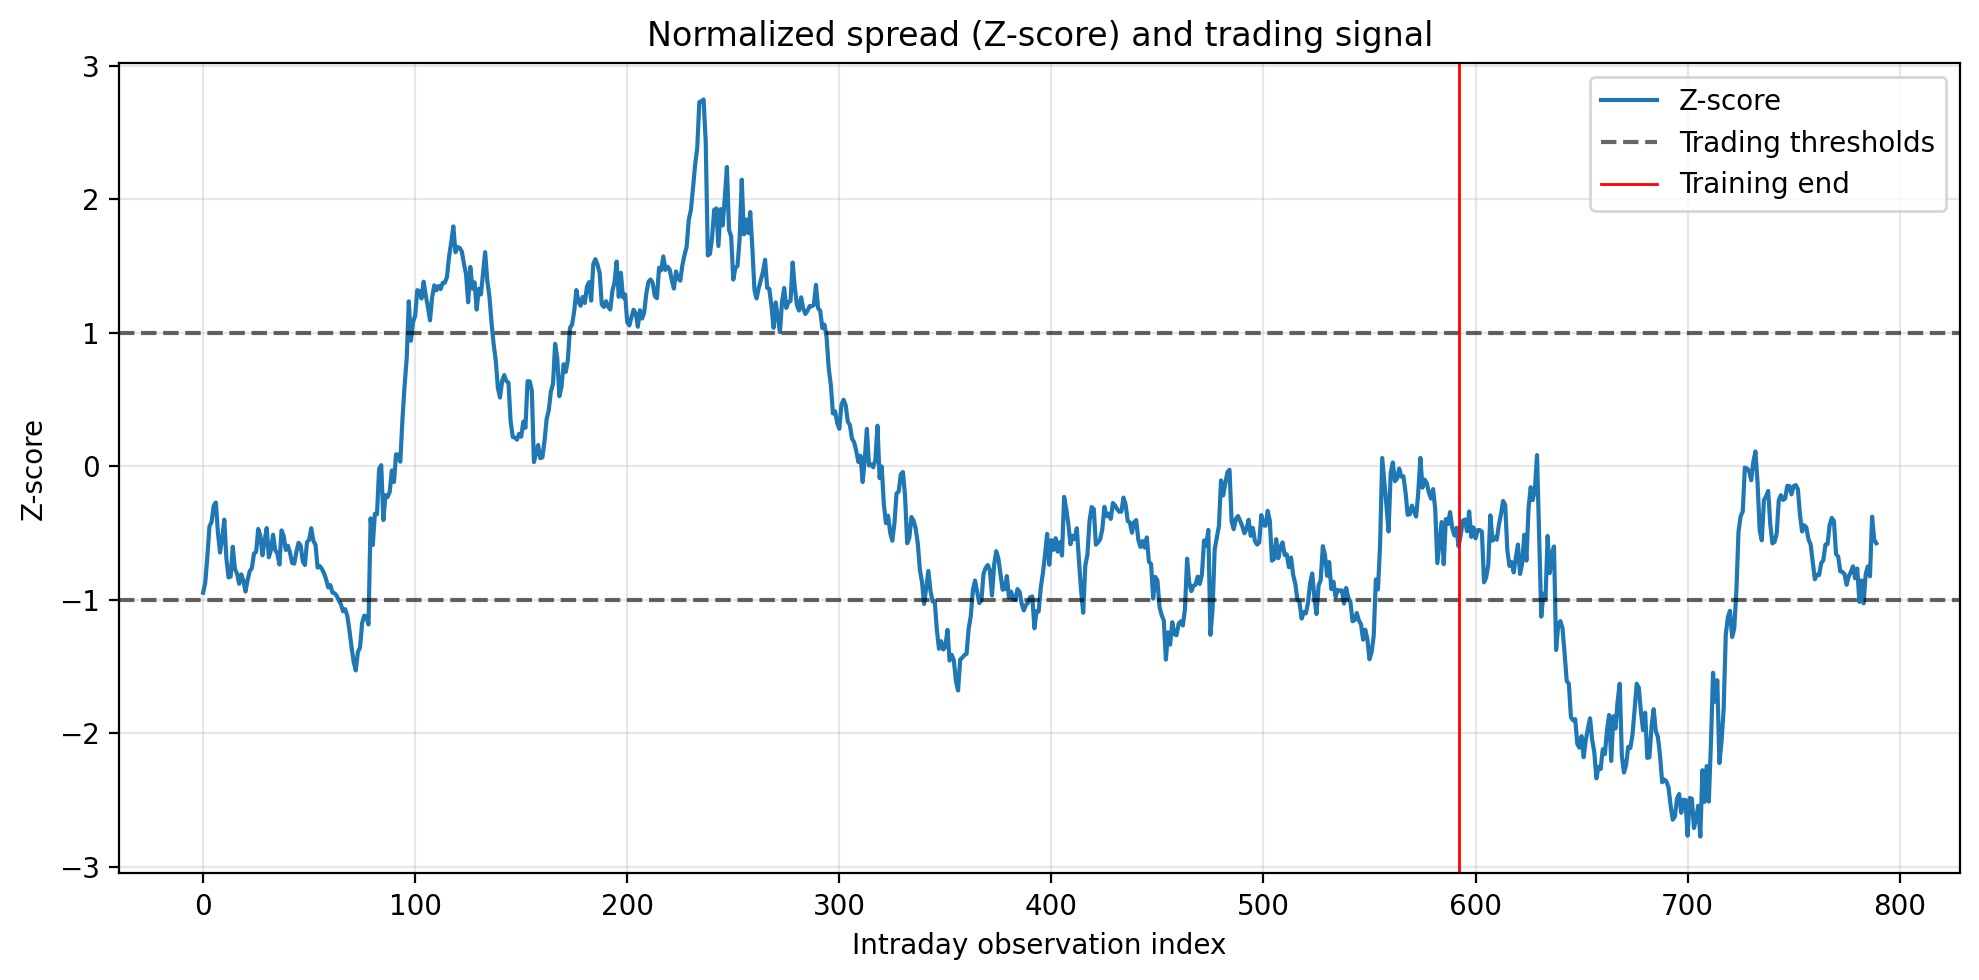

In [6]:
# Normalize the spread (Z-score) –––––

# Compute mean and std of the spread using TRAINING sample only
fSPREAD_MEAN = srSPREAD.iloc[:iT_TRAIN].mean()
fSPREAD_STD  = srSPREAD.iloc[:iT_TRAIN].std()

# Z-score of the spread
srZ = (srSPREAD - fSPREAD_MEAN) / fSPREAD_STD

# Define trading signal –––––
# Simple mean-reversion rule:
# - Long the spread if Z is sufficiently low
# - Short the spread if Z is sufficiently high

fENTRY = 1.0 # entry threshold

srSIGNAL = pd.Series(0, index=srZ.index)

srSIGNAL[srZ < -fENTRY] =  1 # long spread
srSIGNAL[srZ >  fENTRY] = -1 # short spread

# Do not trade during the training period
srSIGNAL.iloc[:iT_TRAIN] = 0

# Plot Z-score and signal –––––

# Create a DataFrame for plotting
dfZ_SEQ = pd.DataFrame({
    "Z": srZ.values,
    "SIGNAL": srSIGNAL.values
})

# Plot
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(dfZ_SEQ["Z"], label="Z-score")
plt.axhline( fENTRY, linestyle="--", color="black", alpha=0.6, label="Trading thresholds")
plt.axhline(-fENTRY, linestyle="--", color="black", alpha=0.6)
plt.axvline(iT_TRAIN, linewidth=1, label="Training end", color="red")
plt.title("Normalized spread (Z-score) and trading signal")
plt.xlabel("Intraday observation index")
plt.ylabel("Z-score")
plt.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


The normalized spread exhibits substantial variation around zero and frequently crosses the predefined entry thresholds. During the training period, deviations beyond ±1 are observed but typically followed by partial reversals, providing a basis for a mean-reversion trading signal. In the test period, larger and more persistent deviations occur, indicating that relative mispricing can widen at intraday horizons and that mean reversion is not guaranteed over short windows. This behavior is consistent with the earlier cointegration results and supports interpreting the strategy as a short-term relative-value trade rather than a strict equilibrium-based arbitrage.

## **3. Strategy performance**

Using the trading signal defined in the previous section, I compute intraday strategy returns and evaluate performance separately on the training and test samples. Performance is summarized using cumulative returns, Sharpe ratios, and maximum drawdowns. To assess robustness, I examine how performance varies with leverage by scaling the portfolio weights while keeping their 1-norm fixed.

Finally, I run a performance attribution regression of strategy returns on market returns to assess whether the strategy exhibits systematic market exposure. Given the intraday and relative-value nature of the strategy, any market beta is expected to be limited.

In [7]:
# Compute intraday returns –––––

# Intraday log returns of each asset
dfRET = dfLOGPRICES.diff()
dfRET_SPY = dfLOGSPY.diff()

# Strategy return:
# r_t = SIGNAL_{t-1} * deltaSPREAD_t
srSPREAD_RET = srSPREAD.diff()

srSTRAT_RET = srSIGNAL.shift(1) * srSPREAD_RET
srSTRAT_RET = srSTRAT_RET.fillna(0)

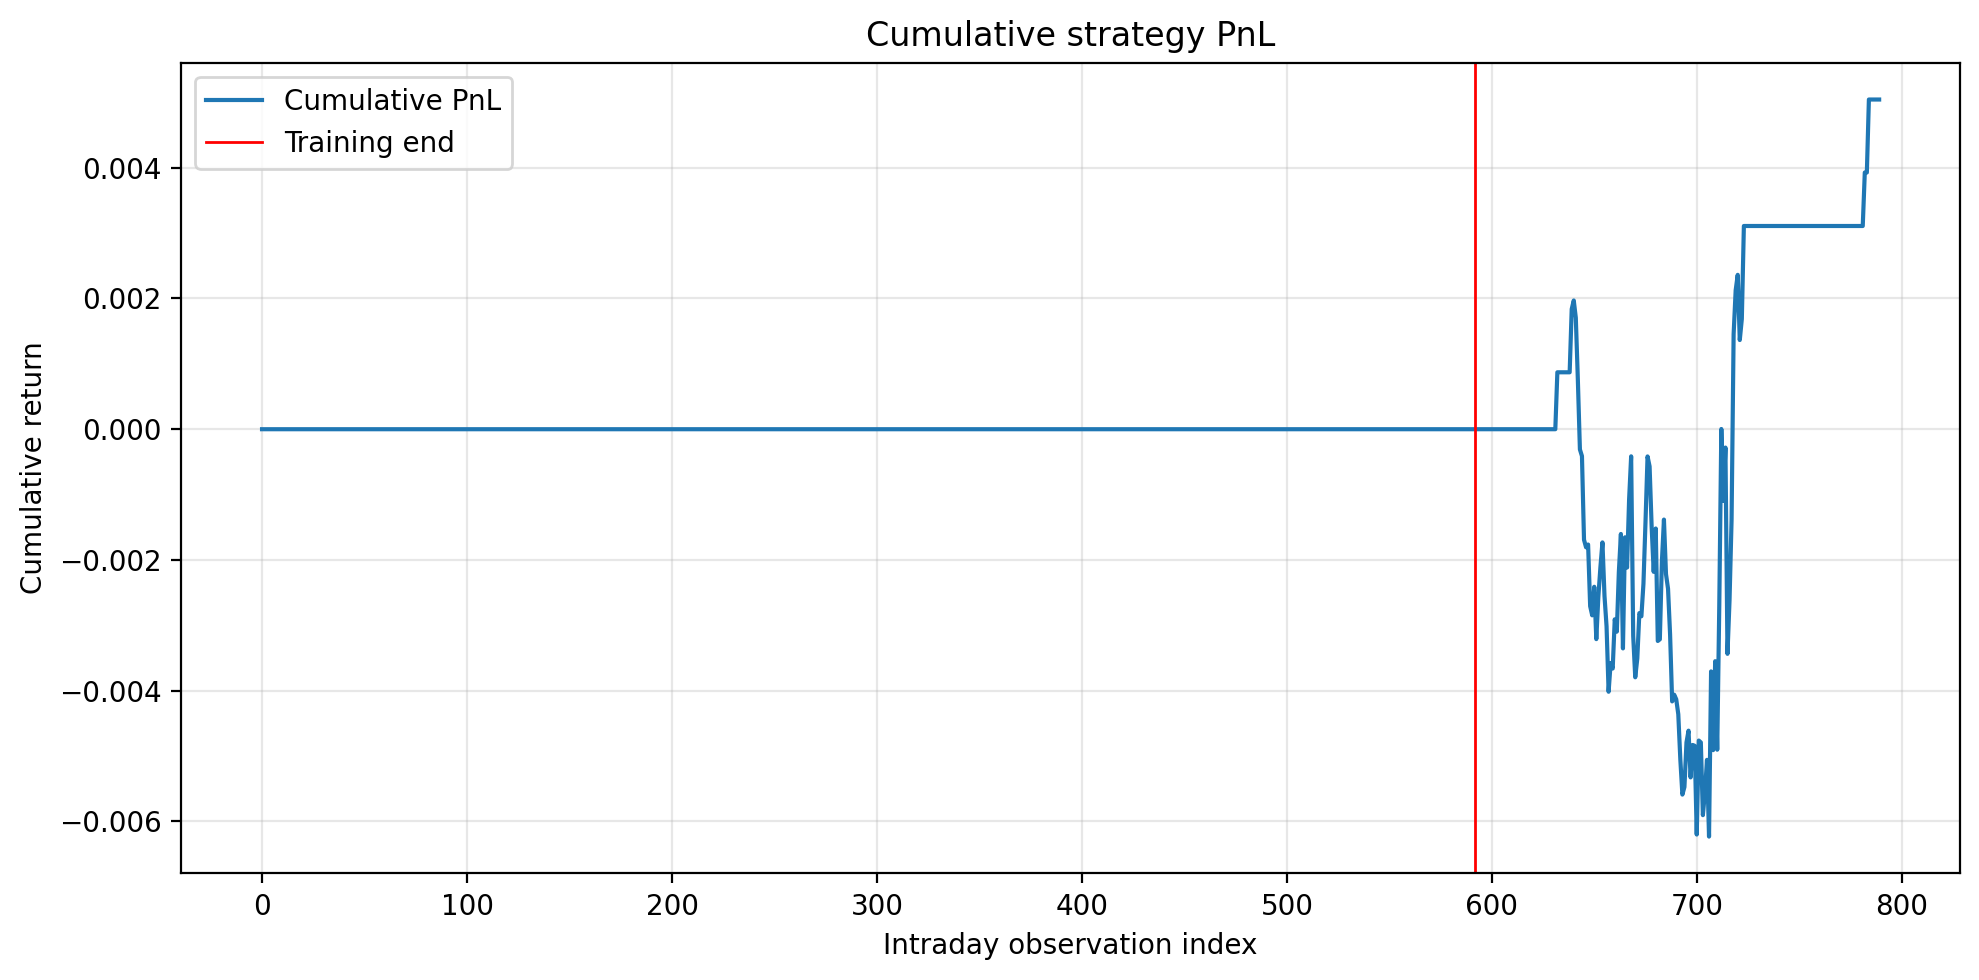

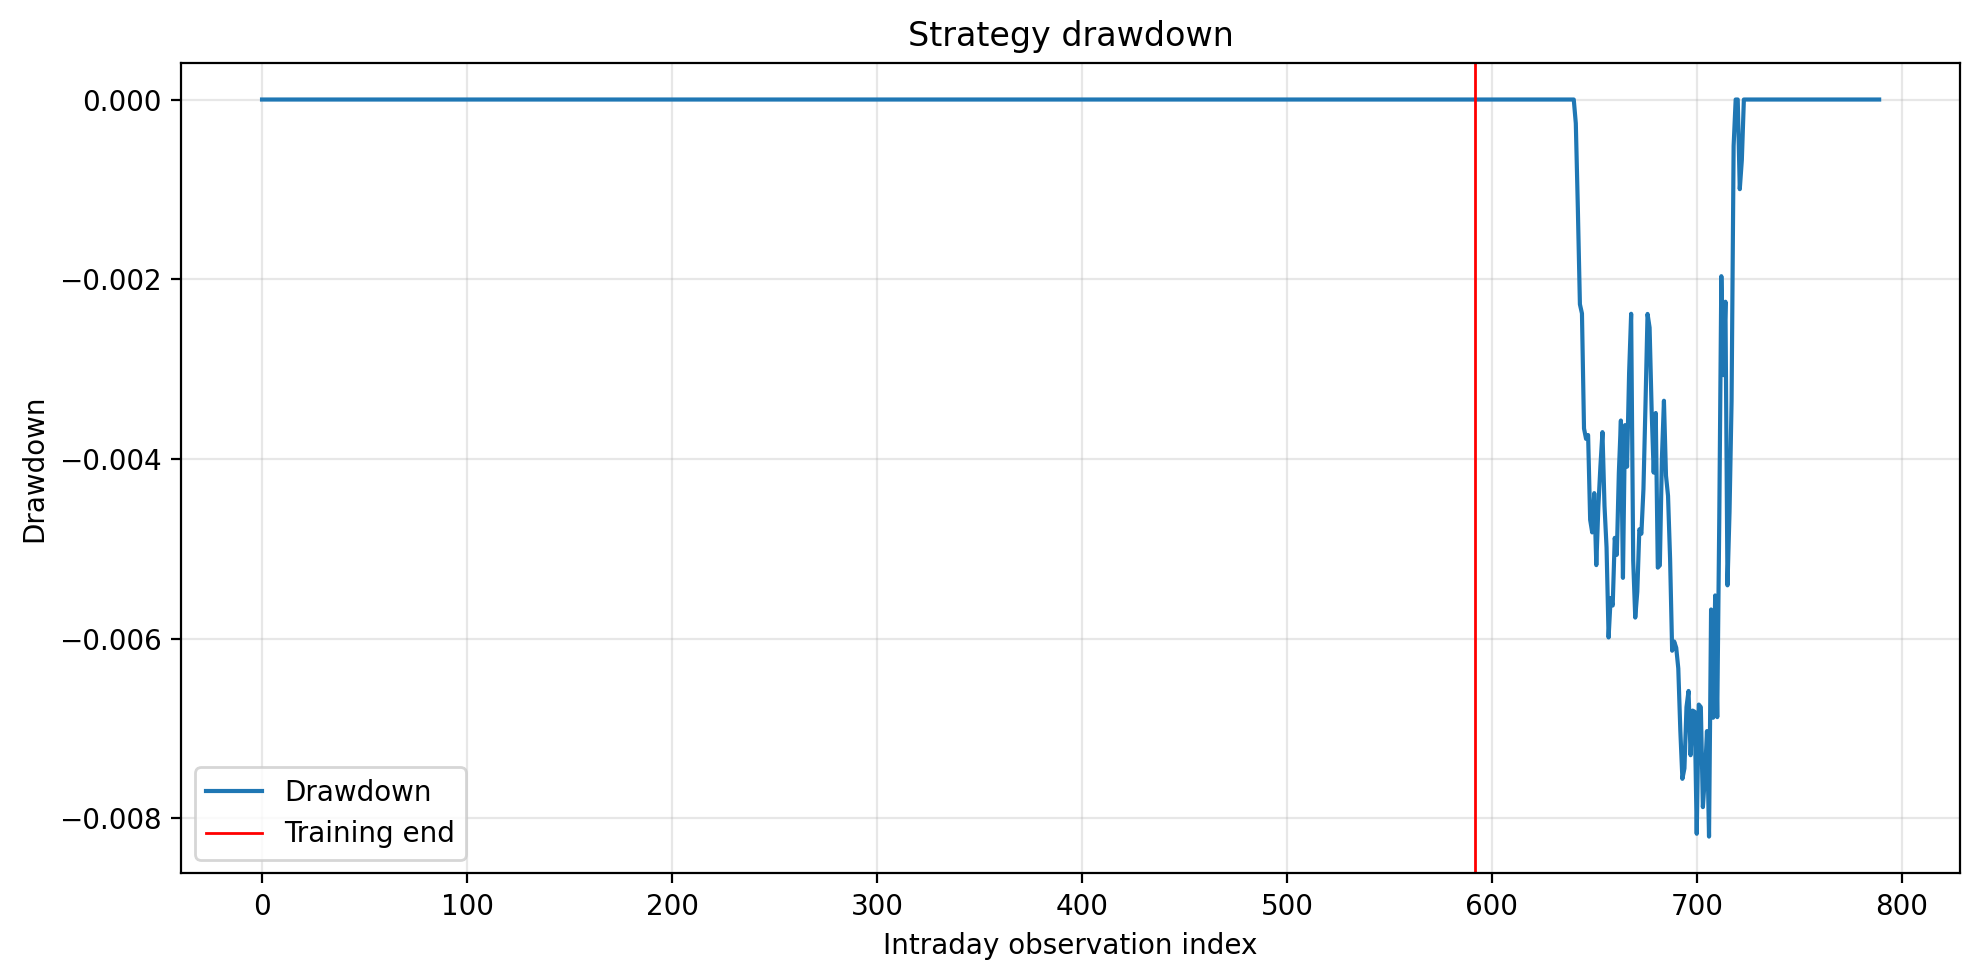

In [8]:
# Cumulative PnL and drawdown –––––

# Cumulative PnL
srCUMPNL = srSTRAT_RET.cumsum()

# Plot cumulative PnL
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(srCUMPNL.reset_index(drop=True), label="Cumulative PnL")
plt.axvline(iT_TRAIN, linewidth=1, label="Training end", color="red")
plt.title("Cumulative strategy PnL")
plt.xlabel("Intraday observation index")
plt.ylabel("Cumulative return")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Drawdown
srROLL_MAX = srCUMPNL.cummax()
srDRAWDOWN = srCUMPNL - srROLL_MAX

# Plot drawdown
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(srDRAWDOWN.reset_index(drop=True), label="Drawdown")
plt.axvline(iT_TRAIN, linewidth=1, label="Training end", color="red")
plt.title("Strategy drawdown")
plt.xlabel("Intraday observation index")
plt.ylabel("Drawdown")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

The cumulative PnL plot shows that trading activity occurs primarily in the test period, as expected given that signals are only activated after the training window. Performance in the test sample is positive overall, although the path of cumulative returns is volatile and includes a pronounced drawdown before recovering toward the end of the sample. This behavior is consistent with a short-horizon intraday strategy that is exposed to temporary widening of relative mispricing before partial mean reversion occurs.

The drawdown plot highlights that the strategy can experience non-negligible losses over short periods, with the maximum drawdown occurring during a phase of persistent spread divergence. This reinforces the earlier interpretation that mean reversion is not guaranteed at intraday horizons and that risk management is an important consideration.

In [9]:
# Performance statistics –––––

# Function to compute performance stats
def performance_stats(returns):
    mu = returns.mean()
    sigma = returns.std()
    fSHARPE = np.sqrt(252 * 78) * mu / sigma if sigma > 0 else np.nan  # intraday annualization
    fTOT_RET = returns.sum()
    fMAX_DD = (returns.cumsum() - returns.cumsum().cummax()).min()
    return fTOT_RET, fSHARPE, fMAX_DD

# Test sample stats
dfTEST_STATS = performance_stats(srSTRAT_RET.iloc[iT_TRAIN:])

# Display test sample performance
print("Performance on TEST sample:")
print(f"Total return: {dfTEST_STATS[0]:.4f}")
print(f"Sharpe ratio: {dfTEST_STATS[1]:.4f}")
print(f"Max drawdown: {dfTEST_STATS[2]:.4f}")


Performance on TEST sample:
Total return: 0.0050
Sharpe ratio: 5.0322
Max drawdown: -0.0082


On the test sample, the strategy achieves a positive total return with a relatively high Sharpe ratio, indicating favorable average performance relative to return volatility over the evaluation window. At the same time, the maximum drawdown is sizable compared to total returns, suggesting that performance is driven by a limited number of profitable episodes and that losses can accumulate before reversals occur. These results are in line with the weak cointegration evidence and support interpreting the strategy as a speculative relative-value trade rather than a low-risk arbitrage.

In [10]:
# Leverage sensitivity –––––

# Define leverage levels to test
lLEVERAGE = np.linspace(1.0, 2.0, 5)

# Initialize results storage
dfLEV_RESULTS = []

# Compute performance stats for each leverage level
for fLEV in lLEVERAGE:
    srRET_LEV = fLEV * srSTRAT_RET.iloc[iT_TRAIN:]
    fTOT_RET, fSHARPE, fMAX_DD = performance_stats(srRET_LEV)
    dfLEV_RESULTS.append([fLEV, fTOT_RET, fSHARPE, fMAX_DD])

# Create DataFrame of leverage results
dfLEV = pd.DataFrame(
    dfLEV_RESULTS,
    columns=["Leverage", "Total return", "Sharpe ratio", "Max drawdown"]
)

# Display leverage sensitivity results
display(dfLEV)

,Leverage,Total return,Sharpe ratio,Max drawdown
0,1.00,0.005044,5.032175,-0.008202
1,1.25,0.006305,5.032175,-0.010253
2,1.50,0.007566,5.032175,-0.012303
3,1.75,0.008827,5.032175,-0.014354
4,2.00,0.010088,5.032175,-0.016404


Increasing leverage scales both returns and risk approximately proportionally. Total returns increase monotonically with leverage, while the Sharpe ratio remains unchanged, reflecting the linear scaling of both mean returns and volatility. In contrast, maximum drawdown increases substantially with leverage, highlighting the trade-off between higher returns and increased downside risk. This pattern suggests that leverage choice is primarily a risk management decision rather than a source of improved risk-adjusted performance.

In [11]:
# Performance attribution –––––

# SPY (as a proxy for market) log returns aligned with strategy returns

# SPY log returns aligned with strategy returns
dfATTR = pd.DataFrame({
    "STRAT": srSTRAT_RET.iloc[iT_TRAIN:],
    "MARKET": dfRET_SPY["SPY"].iloc[iT_TRAIN:]
}).dropna()

# OLS regression of strategy returns on market returns
mdlATTR = smf.ols("STRAT ~ MARKET", data=dfATTR).fit()

# Print regression summary
print(mdlATTR.summary())

                            OLS Regression Results                            
Dep. Variable:                  STRAT   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.004
Date:                Tue, 10 Feb 2026   Prob (F-statistic):              0.159
Time:                        18:35:51   Log-Likelihood:                 1156.2
No. Observations:                 198   AIC:                            -2308.
Df Residuals:                     196   BIC:                            -2302.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.483e-05   5.03e-05      0.494      0.6

The performance attribution regression shows a low $R^2$ and an insignificant coefficient on the market return. This indicates that the strategy’s returns are largely unrelated to broad market movements and that market exposure does not play a dominant role in explaining performance. The lack of a statistically significant market beta is consistent with the construction of the strategy as a market-neutral relative-value trade.

**Final remarks**

This analysis has several limitations. First, the use of intraday data over a relatively short window of ten trading days limits the power of statistical tests for cointegration and increases the influence of microstructure effects and transient liquidity shocks. Second, while Visa and Mastercard are economically closely related, intraday relative pricing can be affected by firm-specific order flow and short-lived information, which may weaken mean reversion over short horizons. As a result, the strategy should be interpreted as an exploratory intraday relative-value exercise rather than a robust equilibrium-based arbitrage. Extending the sample period, considering alternative pairs, or incorporating transaction costs and intraday position constraints would be natural extensions for further analysis.